# Recurrent Neural Networks
Simple Pytorch LSTM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F

import time

import os
import joblib

import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Load the raw data stored in the specified ``csv`` file and inspect the overall data format. Our input is a sequence of closing prices of the stock, and the output is the closing price of the next day. This can be changed

In [2]:
# filepath = 'Bitcoin SV.csv'
filepath = 'bitcoin.csv'
data = pd.read_csv(os.path.join('../data', filepath))
# data = data.sort_values('Date')
data.head()


,Date,Open,High,Low,Close,Volume,Currency
0,2010-07-18,0.0,0.1,0.1,0.1,75,USD
1,2010-07-19,0.1,0.1,0.1,0.1,574,USD
2,2010-07-20,0.1,0.1,0.1,0.1,262,USD
3,2010-07-21,0.1,0.1,0.1,0.1,575,USD
4,2010-07-22,0.1,0.1,0.1,0.1,2160,USD


Plot the raw data.

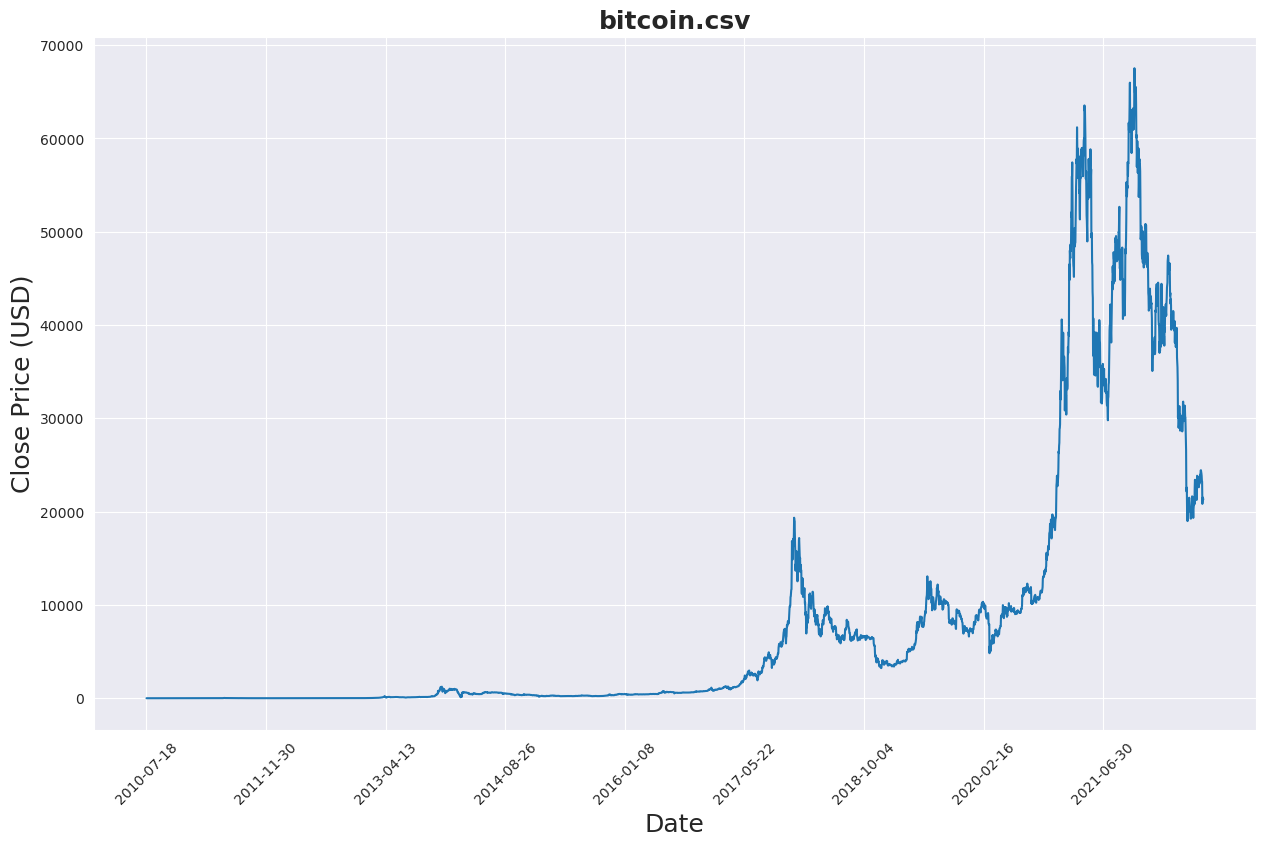

In [3]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title(filepath,fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()


Extract the ``Close`` column in the data frame as our data.

In [4]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4420 entries, 0 to 4419
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4420 non-null   float64
dtypes: float64(1)
memory usage: 34.7 KB


Normalize the raw data into the range of ``[-1, 1]``.

In [5]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/tmp/ipykernel_24752/2141647733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


The following method helps process the raw data into the desired input and output formats, and at the same time splits the train and test data.

In [6]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    x_train = torch.from_numpy(x_train)
    x_test = torch.from_numpy(x_test)
    y_train = torch.from_numpy(y_train)
    y_test = torch.from_numpy(y_test)
    x_train, y_train, x_test, y_test = x_train.float(), y_train.float(), x_test.float(), y_test.float()
    
    return [x_train, y_train, x_test, y_test]


Call the ``split_data`` function to retrieve ``x_train``, ``y_train``, ``x_test`` and ``y_test``.

In [7]:
# process the raw data
# lookback = 20 # choose sequence length
#### START CODE HERE (~1 line) ####
# x_train, y_train, x_test, y_test = split_data(price, lookback)
#### END CODE HERE ####
# print('x_train.shape = ',x_train.shape)
# print('y_train.shape = ',y_train.shape)
# print('x_test.shape = ',x_test.shape)
# print('y_test.shape = ',y_test.shape)


In [8]:
def get_train_test_data(data, lookback: int=20, verbose=True):
    x_train, y_train, x_test, y_test = split_data(data, lookback)
    if verbose:
        print('x_train.shape = ',x_train.shape)
        print('y_train.shape = ',y_train.shape)
        print('x_test.shape = ',x_test.shape)
        print('y_test.shape = ',y_test.shape)
    return x_train, y_train, x_test, y_test

In [9]:
def ablation_study(model, data, lookback, search_params):
    x_train, y_train, x_test, y_test = get_train_test_data(data, lookback, verbose=False)
    clf = GridSearchCV(model, search_params)
    clf.fit(x_train, y_train.ravel())
    return clf

Convert from ``numpy.array`` to ``torch.tensor``.

In [10]:
# Convert to torch Tensor
# x_train = torch.from_numpy(x_train)
# x_test = torch.from_numpy(x_test)
# y_train = torch.from_numpy(y_train)
# y_test = torch.from_numpy(y_test)
# x_train, y_train, x_test, y_test = x_train.float(), y_train.float(), x_test.float(), y_test.float()


Here provides the hyper-parameters for the assignment. You can try changing these hyper-parameters and observe the difference in the model's performance.

In [11]:
# hyper-parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1
num_epochs = 200
learning_rate = 0.001

## Built-in LSTM

1-layer LSTM network using the PyTorch built-in LSTM cell

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # for t in range(x.shape[1]):
        #     _, (ht, ct) = self.lstm(x[:,t], (ht, ct))
        output, (ht, ct) = self.lstm(x, (h0.detach(), c0.detach()))
        output = self.fc(output[:, -1, :]) 
        
        return output

In [13]:
model = NeuralNetRegressor(
    module=LSTM,
    criterion=nn.MSELoss,
    optimizer=torch.optim.Adam,
    verbose=False,
    module__input_dim=1,
    module__hidden_dim=64,
    module__output_dim=1,
    device=device
)

In [14]:
print('Device:', device)

Device: cuda


In [15]:
param_grid = {
    # 'module__input_dim': [1],
    # 'module__hidden_dim': [64],
    'module__num_layers': [1,2,3,4],
    # 'module__output_dim': [1],
    'max_epochs': [50, 100, 150, 200]
}
# grid = GridSearchCV(estimator=model, param_grid=param_grid)
# grid_result = grid.fit(x_train, y_train)

In [16]:
clfs = []
for lookback in [2, 5, 10, 15, 20, 25]:
    print('.', end='')
    clf = ablation_study(model, price, lookback, param_grid)
    clfs.append(clf)

.

.....

In [18]:
for i in range(len(clfs)):
    seq = [2, 5, 10, 15, 20, 25]
    joblib.dump(clfs[i], '../models/rnn/gs_'+str(seq[i])+'seq.pkl')

In [19]:
sequence_len = [2, 5, 10, 15, 20, 25]
rnn_grid_search = []
for i in range(len(sequence_len)):
    rnn_grid_search.append(joblib.load('../models/rnn/gs_'+str(sequence_len[i])+'seq.pkl'))

In [20]:
params = ['max_epochs', 'module__num_layers']
search_params = ['_'.join(['param',param]) for param in params]

In [21]:
for i in range(len(sequence_len)):
    print(rnn_grid_search[i].best_score_)

-9769.610934002778
-8880.701611083332
-14392.8224831086
-10485.729489726604
-23473.61029111067
-20966.463417468123


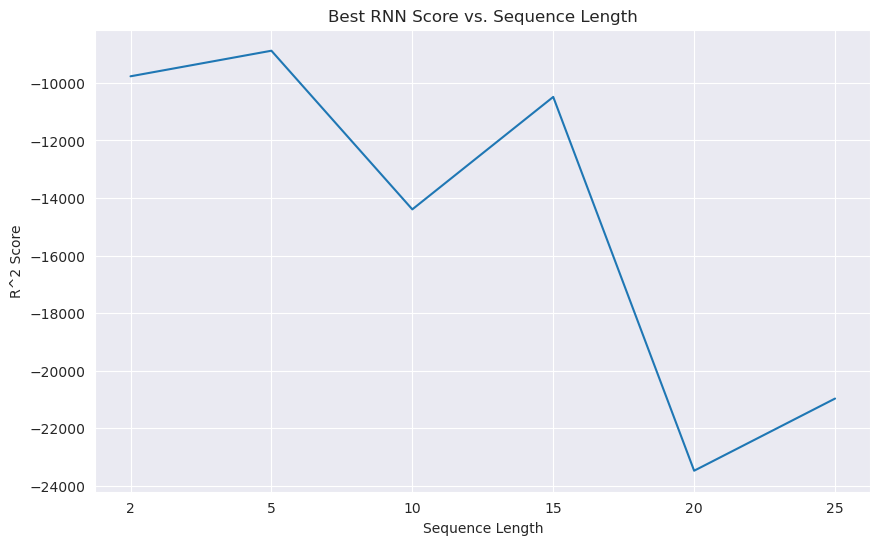

In [24]:
best_acc = []
for i in range(len(sequence_len)):
    best_acc.append(rnn_grid_search[i].best_score_)

ax = plt.figure(figsize=(10,6))
plt.plot(best_acc)
plt.ylabel('R^2 Score')
plt.xlabel('Sequence Length')
plt.xticks(range(len(sequence_len)), [str(s) for s in sequence_len]);
plt.title('Best RNN Score vs. Sequence Length')
plt.savefig('../figures/rnn/best_score_vs_len.png')

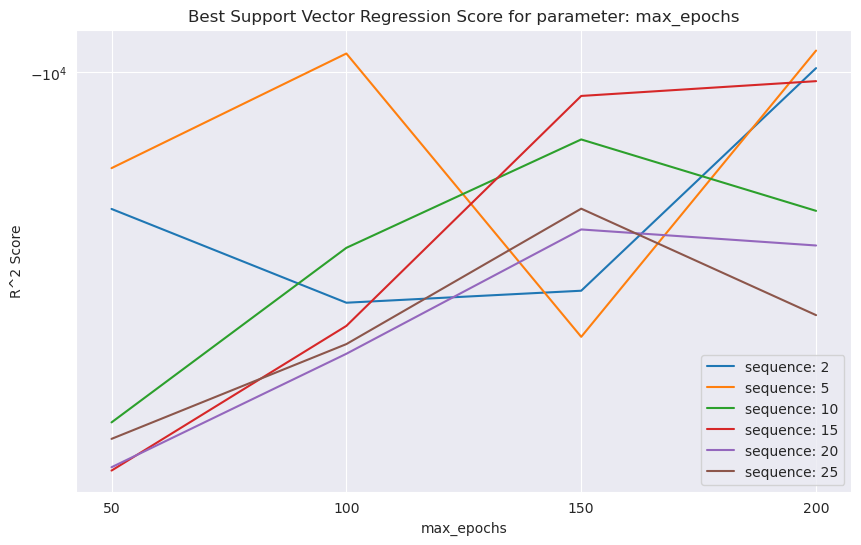

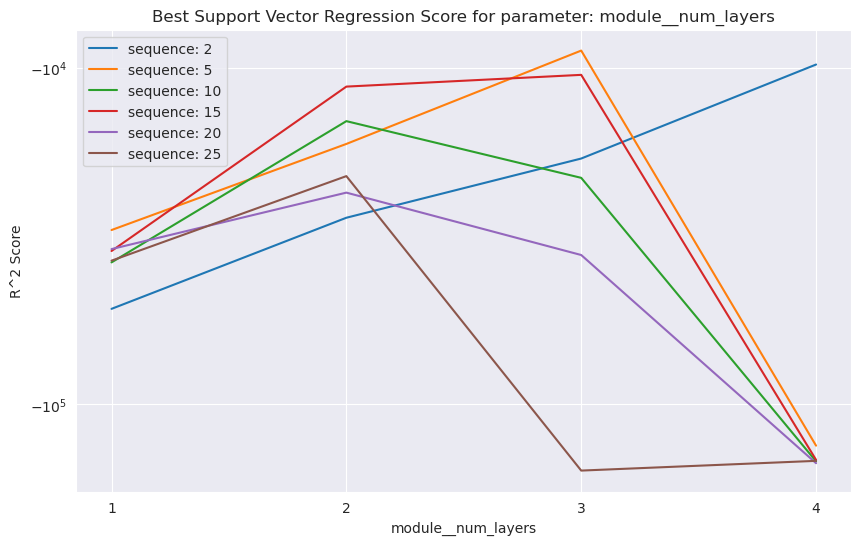

In [25]:
for j in range(len(search_params)):
    param = search_params[j]
    fig = plt.figure(figsize=(10,6))
    index = pd.DataFrame(rnn_grid_search[0].cv_results_).groupby(param)['mean_test_score'].max().index
    for i in range(len(sequence_len)):
        temp = pd.DataFrame(rnn_grid_search[i].cv_results_)
        vals = temp.groupby(param)['mean_test_score'].max()
        plt.plot(vals.values, label='sequence: '+str(sequence_len[i]))
    plt.legend()
    plt.title('Best Support Vector Regression Score for parameter: '+params[j])
    plt.yscale('symlog')
    plt.xlabel(params[j])
    plt.ylabel('R^2 Score')
    plt.xticks(list(range(len(index))), index)
    plt.savefig('../figures/rnn/best_score_vs_'+param+'.png')
    plt.show()

In [ ]:
# summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: -22482.606991 using {'max_epochs': 200, 'module__hidden_dim': 64, 'module__input_dim': 1, 'module__num_layers': 2, 'module__output_dim': 1}
-70114.182901 (139896.161689) with: {'max_epochs': 50, 'module__hidden_dim': 64, 'module__input_dim': 1, 'module__num_layers': 1, 'module__output_dim': 1}
-77948.760234 (154775.323517) with: {'max_epochs': 50, 'module__hidden_dim': 64, 'module__input_dim': 1, 'module__num_layers': 2, 'module__output_dim': 1}
-192085.537597 (383079.345554) with: {'max_epochs': 50, 'module__hidden_dim': 64, 'module__input_dim': 1, 'module__num_layers': 4, 'module__output_dim': 1}
-58693.386660 (117147.770792) with: {'max_epochs': 100, 'module__hidden_dim': 64, 'module__input_dim': 1, 'module__num_layers': 1, 'module__output_dim': 1}
-63133.026878 (126033.567181) with: {'max_epochs': 100, 'module__hidden_dim': 64, 'module__input_dim': 1, 'module__num_layers': 2, 'module__output_dim': 1}
-163705.725652 (326763.236507) with: {'max_epochs': 100, 'module__hidden_dim

In [ ]:
# lstm_model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

In [ ]:
# hist = np.zeros(num_epochs)
# start_time = time.time()

# for t in range(num_epochs):
#     x_train = x_train.to(device)
#     y_train = y_train.to(device)
#     y_train_pred = lstm_model(x_train)

#     loss = criterion(y_train_pred, y_train)
#     print("Epoch ", t, "MSE: ", loss.item())
#     hist[t] = loss.item()

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
# training_time = time.time()-start_time
# print("Training time: {}".format(training_time))

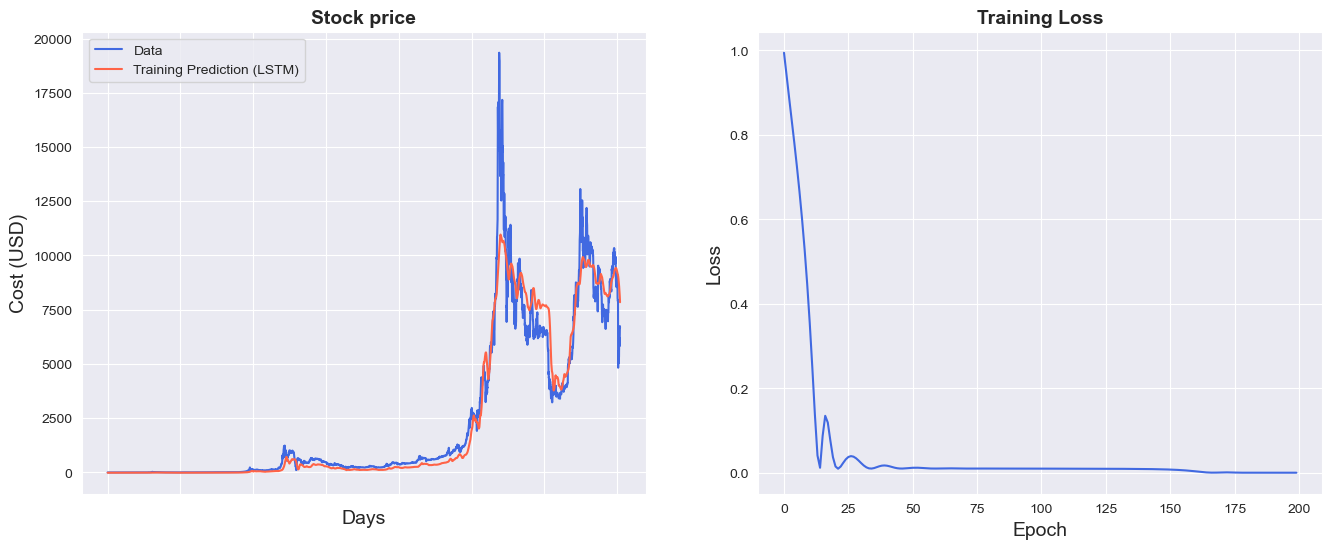

In [ ]:
# predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().cpu().numpy()))
# original = pd.DataFrame(scaler.inverse_transform(y_train.detach().cpu().numpy()))

# sns.set_style("darkgrid")    

# fig = plt.figure()
# fig.subplots_adjust(hspace=0.2, wspace=0.2)

# plt.subplot(1, 2, 1)
# ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
# ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
# ax.set_title('Stock price', size = 14, fontweight='bold')
# ax.set_xlabel("Days", size = 14)
# ax.set_ylabel("Cost (USD)", size = 14)
# ax.set_xticklabels('', size=10)


# plt.subplot(1, 2, 2)
# ax = sns.lineplot(data=hist, color='royalblue')
# ax.set_xlabel("Epoch", size = 14)
# ax.set_ylabel("Loss", size = 14)
# ax.set_title("Training Loss", size = 14, fontweight='bold')
# fig.set_figheight(6)
# fig.set_figwidth(16)


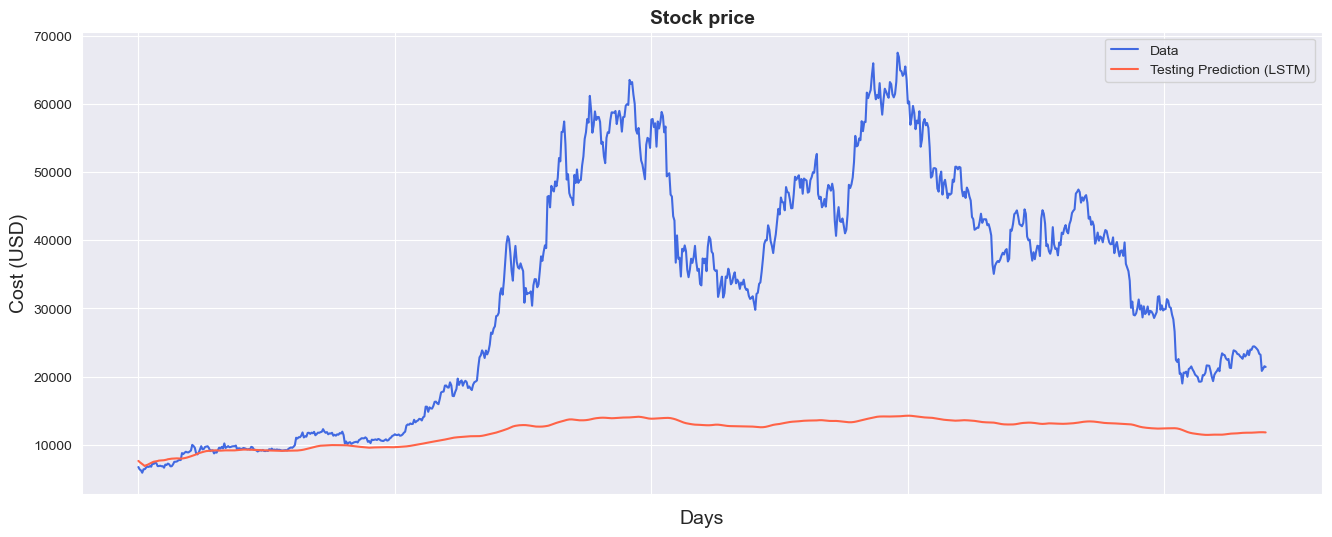

In [ ]:
# # make predictions
# with torch.no_grad():
#     x_test = x_test.to(device)
#     y_test_pred = lstm_model(x_test)

# predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().cpu().numpy()))
# original_test = pd.DataFrame(scaler.inverse_transform(y_test.detach().cpu().numpy()))

# sns.set_style("darkgrid")    

# fig = plt.figure()
# fig.subplots_adjust(hspace=0.2, wspace=0.2)

# plt.subplot(1, 1, 1)
# ax = sns.lineplot(x = original_test.index, y = original_test[0], label="Data", color='royalblue')
# ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Testing Prediction (LSTM)", color='tomato')
# ax.set_title('Stock price', size = 14, fontweight='bold')
# ax.set_xlabel("Days", size = 14)
# ax.set_ylabel("Cost (USD)", size = 14)
# ax.set_xticklabels('', size=10)

# fig.set_figheight(6)
# fig.set_figwidth(16)

In [ ]:
# # calculate root mean squared error
# y_train2 = y_train.detach().cpu().numpy()
# y_train_pred = y_train_pred.detach().cpu().numpy()
# trainScore = np.sqrt(metrics.mean_squared_error(y_train2[:,0], y_train_pred[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))

# y_test2 = y_test.detach().cpu().numpy()
# y_test_pred = y_test_pred.detach().cpu().numpy()
# testScore = np.sqrt(metrics.mean_squared_error(y_test2[:,0], y_test_pred[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.03 RMSE
Test Score: 0.76 RMSE


## Built-in GRU

1-layer GRU network using the PyTorch built-in GRU cell.

In [ ]:
# class GRU(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
#         super(GRU, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
        
#         self.gru_cell = nn.GRUCell(input_dim, hidden_dim, bias=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         ht = torch.zeros(x.size(0), self.hidden_dim).requires_grad_()

#         for t in range(x.shape[1]):
#             ht = self.gru_cell(x[:,t], ht)
#         out = self.fc(ht) 
#         return out

In [ ]:
# gru_model = GRU(input_dim, hidden_dim, 1, output_dim).to(device)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)

In [ ]:
# hist = np.zeros(num_epochs)
# start_time = time.time()

# for t in range(num_epochs):
#     x_train = x_train.to(device)
#     y_train = y_train.to(device)
#     y_train_pred = gru_model(x_train)

#     loss = criterion(y_train_pred, y_train)
#     print("Epoch ", t, "MSE: ", loss.item())
#     hist[t] = loss.item()

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
# training_time = time.time()-start_time
# print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.5042426586151123
Epoch  1 MSE:  0.46123045682907104
Epoch  2 MSE:  0.41922619938850403
Epoch  3 MSE:  0.3782261610031128
Epoch  4 MSE:  0.3382680118083954
Epoch  5 MSE:  0.2993924915790558
Epoch  6 MSE:  0.2616472542285919
Epoch  7 MSE:  0.2251121997833252
Epoch  8 MSE:  0.18991459906101227
Epoch  9 MSE:  0.15624970197677612
Epoch  10 MSE:  0.12440408021211624
Epoch  11 MSE:  0.09477941691875458
Epoch  12 MSE:  0.06792090833187103
Epoch  13 MSE:  0.04454862326383591
Epoch  14 MSE:  0.025579629465937614
Epoch  15 MSE:  0.012110904790461063
Epoch  16 MSE:  0.0052871499210596085
Epoch  17 MSE:  0.0058747208677232265
Epoch  18 MSE:  0.013253734447062016
Epoch  19 MSE:  0.024137629196047783
Epoch  20 MSE:  0.03345160558819771
Epoch  21 MSE:  0.037664953619241714
Epoch  22 MSE:  0.036320529878139496
Epoch  23 MSE:  0.031039506196975708
Epoch  24 MSE:  0.0240285936743021
Epoch  25 MSE:  0.01713400147855282
Epoch  26 MSE:  0.011498495005071163
Epoch  27 MSE:  0.007593044545501

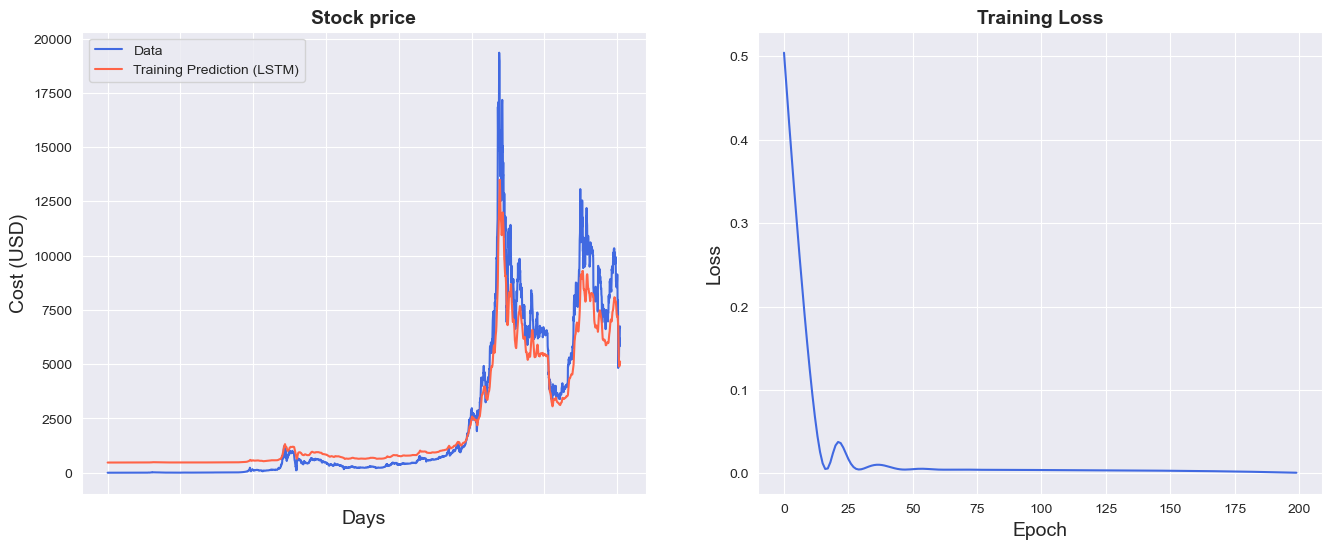

In [ ]:
# predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().cpu().numpy()))
# original = pd.DataFrame(scaler.inverse_transform(y_train.detach().cpu().numpy()))

# sns.set_style("darkgrid")    

# fig = plt.figure()
# fig.subplots_adjust(hspace=0.2, wspace=0.2)

# plt.subplot(1, 2, 1)
# ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
# ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
# ax.set_title('Stock price', size = 14, fontweight='bold')
# ax.set_xlabel("Days", size = 14)
# ax.set_ylabel("Cost (USD)", size = 14)
# ax.set_xticklabels('', size=10)


# plt.subplot(1, 2, 2)
# ax = sns.lineplot(data=hist, color='royalblue')
# ax.set_xlabel("Epoch", size = 14)
# ax.set_ylabel("Loss", size = 14)
# ax.set_title("Training Loss", size = 14, fontweight='bold')
# fig.set_figheight(6)
# fig.set_figwidth(16)

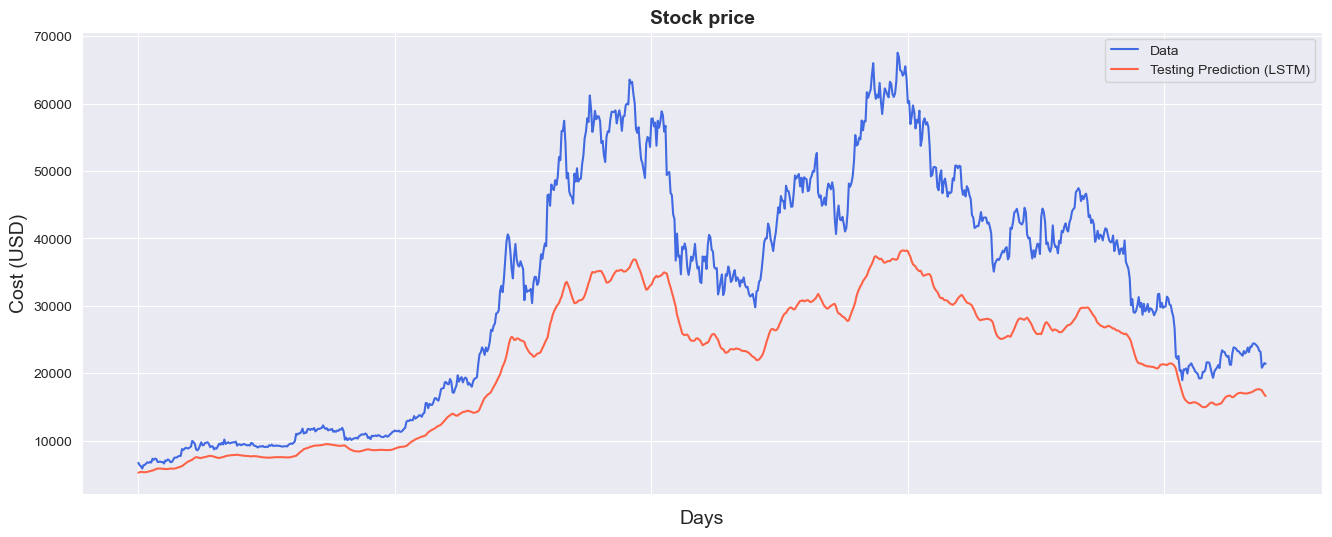

In [ ]:
# # make predictions
# with torch.no_grad():
#     x_test = x_test.to(device)
#     y_test_pred = gru_model(x_test)

# predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().cpu().numpy()))
# original_test = pd.DataFrame(scaler.inverse_transform(y_test.detach().cpu().numpy()))

# sns.set_style("darkgrid")    

# fig = plt.figure()
# fig.subplots_adjust(hspace=0.2, wspace=0.2)

# plt.subplot(1, 1, 1)
# ax = sns.lineplot(x = original_test.index, y = original_test[0], label="Data", color='royalblue')
# ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Testing Prediction (LSTM)", color='tomato')
# ax.set_title('Stock price', size = 14, fontweight='bold')
# ax.set_xlabel("Days", size = 14)
# ax.set_ylabel("Cost (USD)", size = 14)
# ax.set_xticklabels('', size=10)

# fig.set_figheight(6)
# fig.set_figwidth(16)

In [ ]:
# # calculate root mean squared error
# y_train2 = y_train.detach().cpu().numpy()
# y_train_pred = y_train_pred.detach().cpu().numpy()
# trainScore = np.sqrt(metrics.mean_squared_error(y_train2[:,0], y_train_pred[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))

# y_test2 = y_test.detach().cpu().numpy()
# y_test_pred = y_test_pred.detach().cpu().numpy()
# testScore = np.sqrt(metrics.mean_squared_error(y_test2[:,0], y_test_pred[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.03 RMSE
Test Score: 0.39 RMSE
